<a href="https://colab.research.google.com/github/Aiden-Ross-Dsouza/Natural-Language-Processing/blob/main/Neural_Machine_Translation/notebooks/Attention_is_all_you_Need.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing packages

In [ ]:
pip install datasets #Hugging face datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
  

# Importing Required Libraries

In [ ]:
import math
from typing import Any
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import warnings

# Input Embedding Layer with Scaled Embeddings

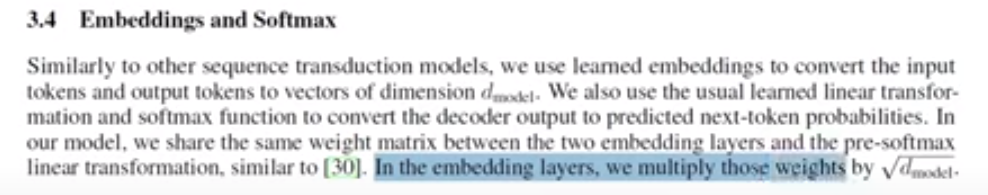

In [ ]:
class InputEmbeddings(nn.Module):
  def __init__(self, d_model: int, vocab_size: int):
    super().__init__() # super(InputEmbeddings, self),init() maybe
    self.d_model = d_model #d_model = embedding size = 512
    self.vocab_size = vocab_size
    self.embedding = nn.Embedding(vocab_size, d_model)

  def forward(self, x):
    return self.embedding(x) * math.sqrt(self.d_model)

# Positional Encoding Layer

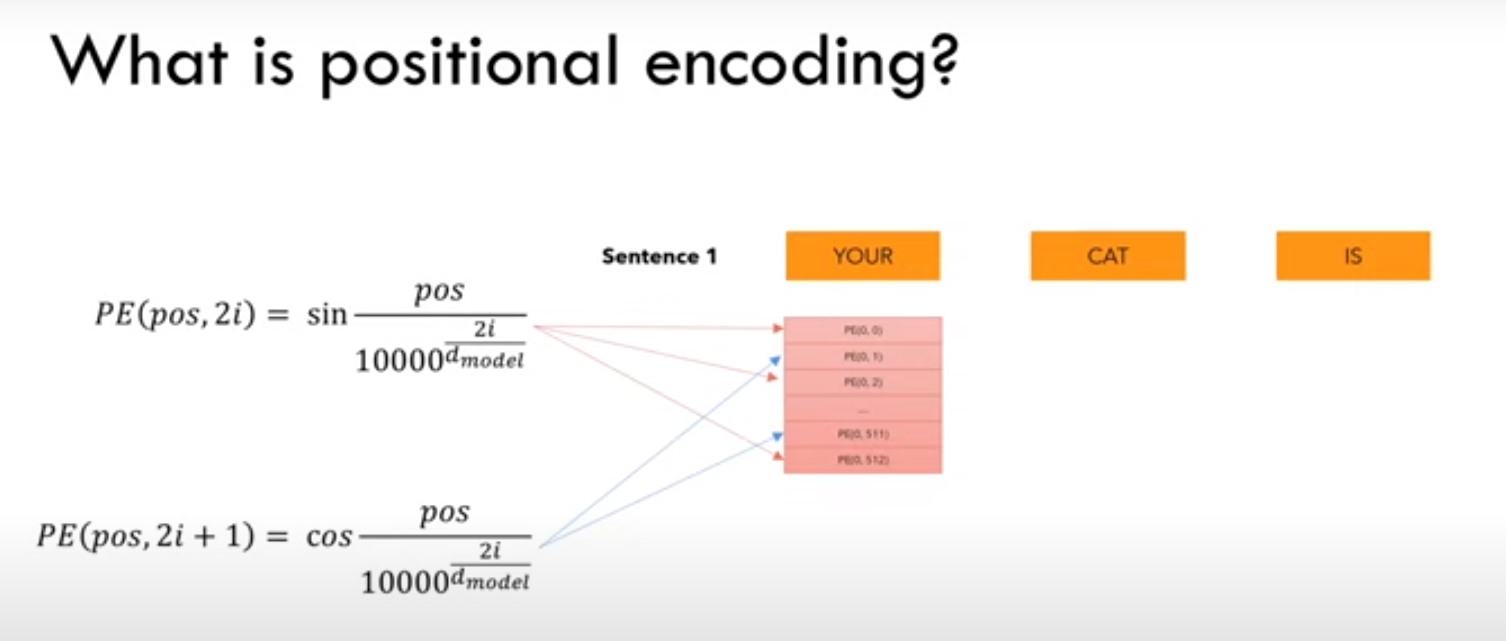

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model: int, seq_len: int, dropout: float): #d_model is dim of positional encoding, seq_len number of positional encoding vectors, dropout to reduce overfitting
    super().__init__()
    self.d_model = d_model
    self.seq_len = seq_len
    self.dropout = nn.Dropout(dropout)

    pe = torch.zeros(seq_len, d_model) #(seq_len, d_model) or (seq_len, 512)
    position = torch.arange(0, seq_len, dtype = torch.float).unsqueeze(1) # (seq_len, 1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model)) # (d_model/2) #Changed denom of original paper to log space calculation for numerical stability
    pe[:, 0::2] = torch.sin(position*div_term) #For all words in sentence, the even positions of the embedidngs will have sine
    pe[:, 1::2] = torch.sin(position*div_term) ##For all words in sentence, the odd positions of the embedidngs will have cosine

    pe = pe.unsqueeze(0) #(1, seq_len, d_model) or (1, seq_len, 512) #We will have a batch of sentences, therefore added dimension for the batch

    self.register_buffer('pe', pe) #saving entire tensor when saving file and not just learnable params

  def forward(self, x):
    x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False) #(1, seq_len, d_model) # PE are fixed, so we make them non learnable/ trainable
    return self.dropout(x)

# Layer Normalization

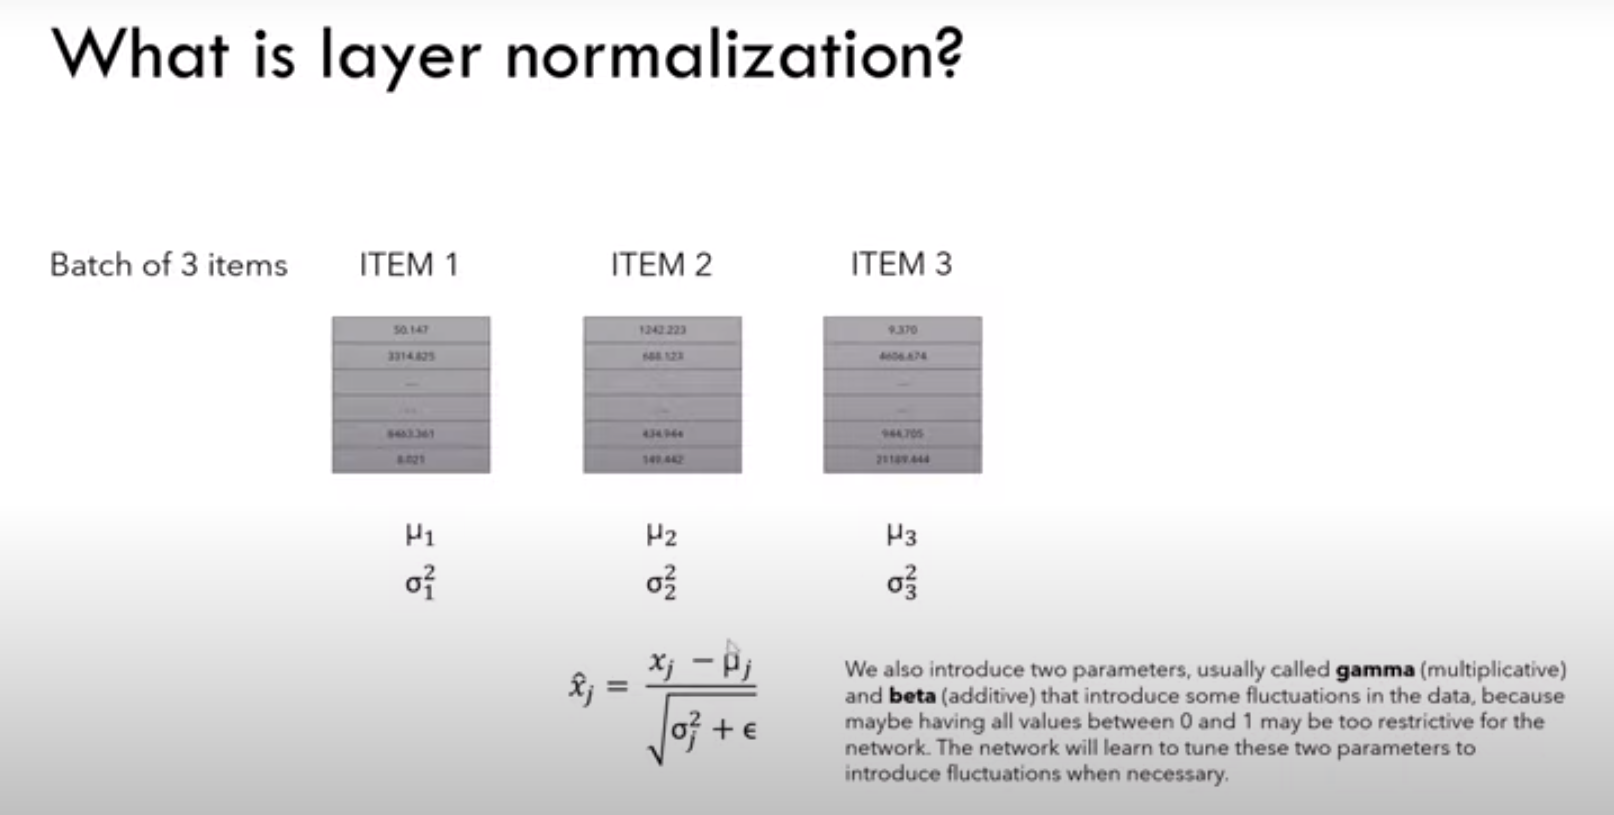

In [ ]:
class LayerNormalization(nn.Module):
  def __init__(self, epsilon: float = 10**-6):
    super().__init__()
    self.epsilon = epsilon
    self.gamma = nn.Parameter(torch.ones(1))
    self.beta = nn.Parameter(torch.zeros(1))

  def forward(self, x):
    mean = x.mean(dim = -1, keepdim = True) #Want to find mean and std dev across features which is the d_model dim in (batch_size, seq_len, 512)
    std_dev = x.std(dim = -1, keepdim = True)
    x = (x - mean)/ (std_dev + self.epsilon)
    return self.gamma*x + self.beta

# Feed Forward Block

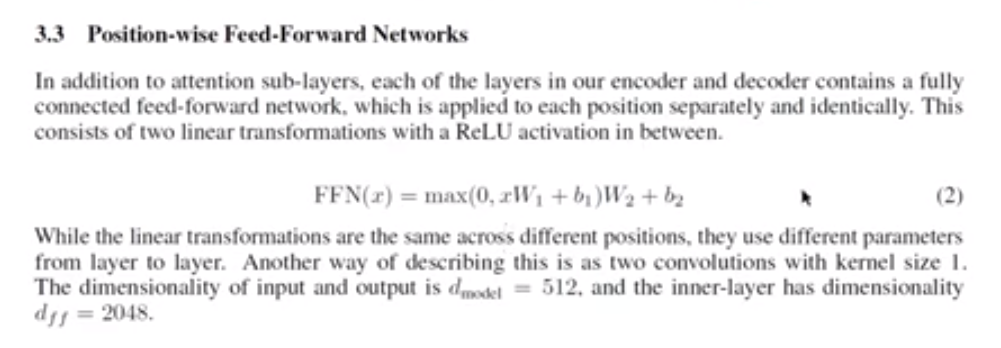

In [ ]:
class FeedForwardBlock(nn.Module):
  def __init__(self, d_model: int, d_ff: int, dropout: float):
    super().__init__()
    self.linear_1 = nn.Linear(d_model, d_ff) # W1, B1
    self.dropout = nn.Dropout(dropout)
    self.linear_2 = nn.Linear(d_ff, d_model) # W2, B2

  def forward(self, x): # x: (batch_size, seq_len, d_model)
    z1 = self.linear_1(x) # z1: (batch_size, seq_len, d_ff)
    a1 = self.dropout(torch.relu(z1)) # a1: (batch_size, seq_len, d_ff)
    a2 = self.linear_2(a1) # a2: (batch_size, seq_len, d_model)
    return a2

# Multi-head Attention Block

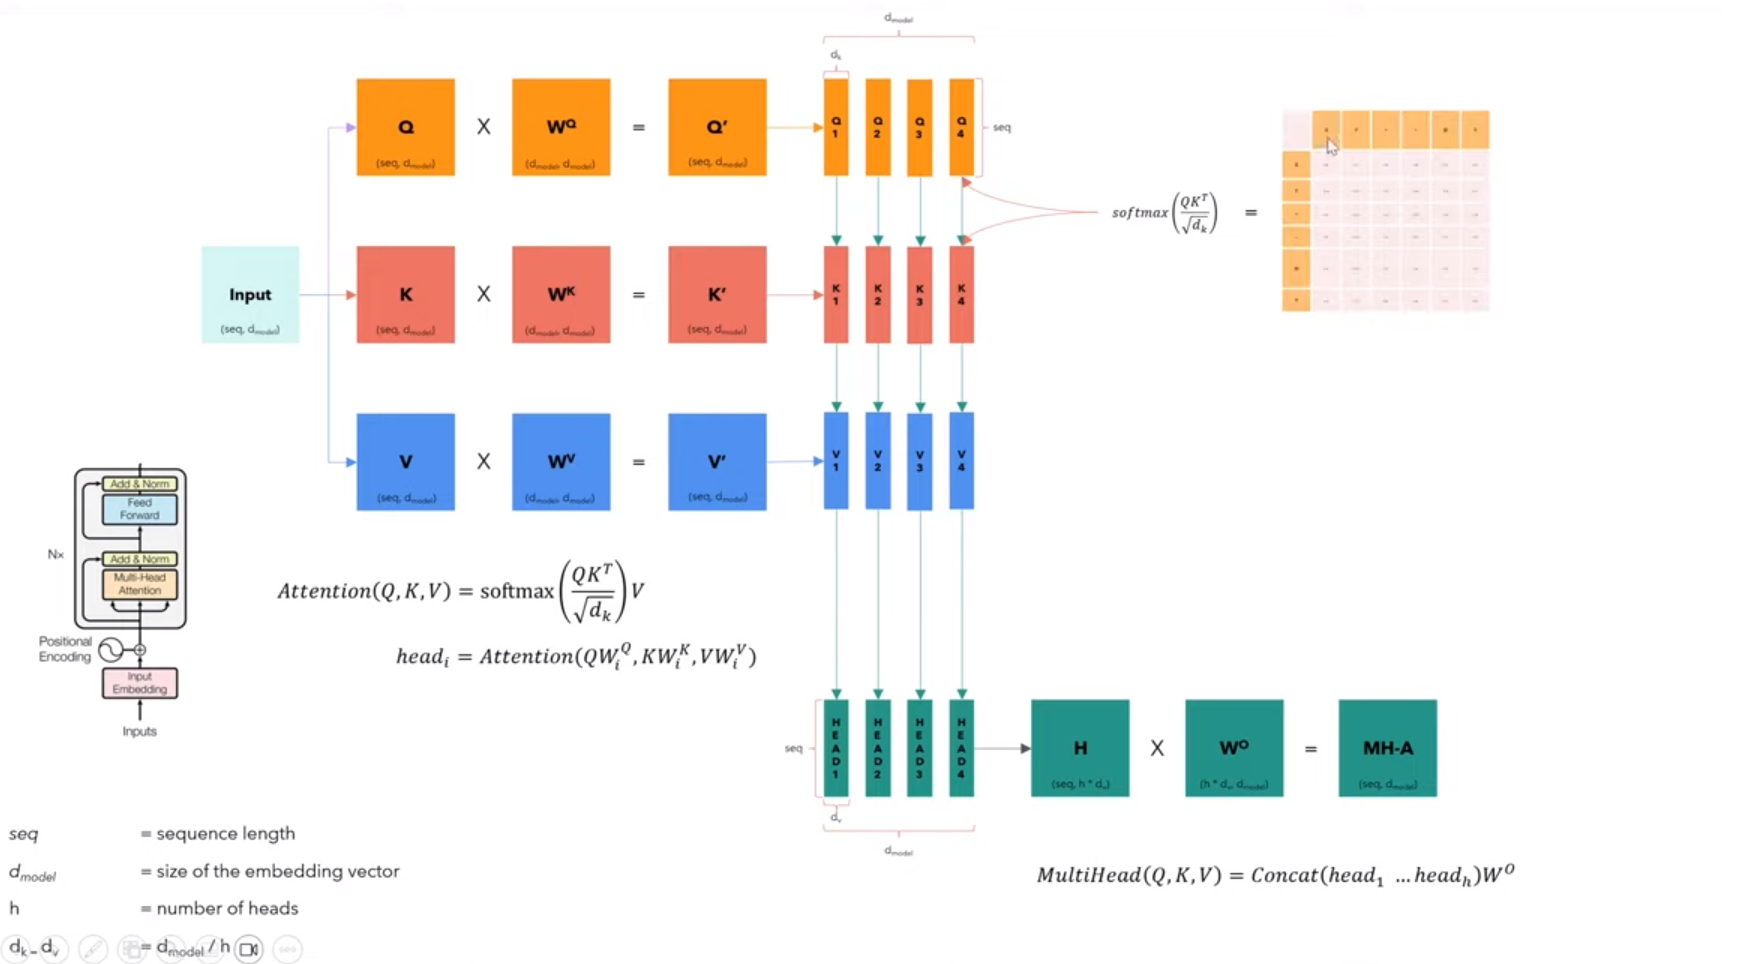

In [ ]:
class MultiheadAttentionBlock(nn.Module):
  def __init__(self, d_model: int, h: int, dropout: float): #Divide Q', K', V' along embedding direction into h units where h is number of heads
    super().__init__()
    self.d_model = d_model
    self.h = h
    assert d_model % h == 0, "d_model is not divisible by h"

    self.d_k = d_model//h
    self.w_q = nn.Linear(d_model, d_model) # w_q = (d_model, d_model)
    self.w_k = nn.Linear(d_model, d_model)
    self.w_v = nn.Linear(d_model, d_model)
    self.w_o = nn.Linear(d_model, d_model) # w_0: (h*d_v, d_model) = (h*d_k, d_model) = (d_mmodel, d_model)
    self.dropout = nn.Dropout(dropout)

  @staticmethod
  def attention(q_prime, k_prime, v_prime, mask, dropout: nn.Dropout): # q_prime: (batch_size, h, seq_len, d_k)
    d_k = q_prime.shape[-1]

    attention_scores = (q_prime @ k_prime.transpose(-2, -1)) / math.sqrt(d_k) # attention_scores: (batch_size, h, seq_len, seq_len)
    if mask is not None:
      attention_scores.masked_fill_(mask==0, -1e9)
    attention_scores = attention_scores.softmax(dim = -1)
    if dropout is not None:
      attention_scores = dropout(attention_scores)

    return (attention_scores @ v_prime), attention_scores # (batch_size, h, seq_len, seq_len) -> (batch_size, h, seq_len, d_k)

  def forward(self, q, k, v, mask): #Mask: If we don't want some words to interact with some other words in the stage Q KT, then we replace their attention score (in the yellow box) with a very small number such that softmax applied on it will tend to 0
    q_prime = self.w_q(q)  # q, q_prime: (batch_size, seq_len, d_model)
    k_prime = self.w_k(k)
    v_prime = self.w_v(v)

    q_prime = q_prime.view(q_prime.shape[0], q_prime.shape[1], self.h, self.d_k).transpose(1,2) # (batch_size, seq_len, d_model) -> (batch_size, seq_len, h, d_k) -> (batch_size, h, seq_len, d_k)
    k_prime = k_prime.view(k_prime.shape[0], k_prime.shape[1], self.h, self.d_k).transpose(1,2)
    v_prime = v_prime.view(v_prime.shape[0], v_prime.shape[1], self.h, self.d_k).transpose(1,2)

    x, self.attention_scores = MultiheadAttentionBlock.attention(q_prime, k_prime, v_prime, mask, self.dropout)
    x = x.transpose(1,2).contiguous().view(x.shape[0], -1, self.h * self.d_k) # (batch_size, h, seq_len, d_k) -> (batch_size, seq_len, h, d_k) -> (batch_size, seq_len, d_model)
    return self.w_o(x)

# Residual Connection

In [ ]:
class ResidualConnection(nn.Module):
  def __init__(self, dropout: float):
    super().__init__()
    self.dropout = nn.Dropout(dropout)
    self.norm = LayerNormalization()

  def forward(self, x, sublayer): # (batch_size, seq_len, d_model)
    return x + self.dropout(sublayer(self.norm(x))) #In the paper they first apply sublayer then apply normalization on x

# Encoder

In [ ]:
class EncoderBlock(nn.Module):
  def __init__(self, self_attention_block: MultiheadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float):
    super().__init__()
    self.self_attention_block = self_attention_block
    self.feed_forward_block = feed_forward_block
    self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])

  def forward(self, x, src_mask): #We need source_mask for input of the encoder bcoz we don't want paddding word to interact with other words
    x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
    x = self.residual_connections[1](x, self.feed_forward_block)
    return x

In [ ]:
class Encoder(nn.Module):
  def __init__(self, layers: nn.ModuleList):
    super().__init__()
    self.layers = layers
    self.norm = LayerNormalization()

  def forward(self, x, mask):
    for layer in self.layers:
      x = layer(x, mask)
    return self.norm(x)

# Decoder

In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self, self_attention_block: MultiheadAttentionBlock, cross_attention_block: MultiheadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float):
    super().__init__()
    self.self_attention_block = self_attention_block
    self.cross_attention_block = cross_attention_block
    self.feed_forward_block = feed_forward_block
    self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)])

  def forward(self, x, encoder_output, src_mask, tgt_mask): #Src_mask: applied to encoder, tgt_mask: applied to decoder
    x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
    x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask)) #key and value from encoder
    x = self.residual_connections[2](x, self.feed_forward_block)
    return x

In [ ]:
class Decoder(nn.Module):
  def __init__(self, layers: nn.ModuleList):
    super().__init__()
    self.layers = layers
    self.norm = LayerNormalization()

  def forward(self, x, encoder_output, src_mask, tgt_mask):
    for layer in self.layers:
      x = layer(x, encoder_output, src_mask, tgt_mask)
    return self.norm(x)

# Projection Layer

In [ ]:
class ProjectionLayer(nn.Module):
  def __init__(self, d_model: int, vocab_size: int):
    super().__init__()
    self.proj = nn.Linear(d_model, vocab_size)

  def forward(self, x):
    return torch.log_softmax(self.proj(x), dim = -1) # (batch_size, seq_len, d_model) -> (batch_size, seq_len, vocab_size)

# Transformer

In [ ]:
class Transformer(nn.Module):
  def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.tgt_embed = tgt_embed
    self.src_pos = src_pos
    self.tgt_pos = tgt_pos
    self.projection_layer = projection_layer

  # 3 different forward blocks
  def encode(self, src, src_mask):
    src = self.src_embed(src)
    src = self.src_pos(src)
    return self.encoder(src, src_mask)

  def decode(self, encoder_output, src_mask, tgt, tgt_mask):
    tgt = self.tgt_embed(tgt)
    tgt = self.tgt_pos(tgt)
    return self.decoder(tgt, encoder_output,src_mask, tgt_mask) #This is forward method of decoder class

  def project(self, x):
    return self.projection_layer(x)

# Model Initialization

In [ ]:
#initializing and getting all blocks together, given all hyperparams -> build model

def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int = 512, N: int = 3, h: int = 8, dropout: float = 0.1, d_ff:int = 2048) -> Transformer: #N is no of encoder/ decoder blocks to be used, h is no of heads
  #Create the embedding layers
  src_embed = InputEmbeddings(d_model, src_vocab_size)
  tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)

  #Create the positional encoding layers
  src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
  tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)

  #Create the encoder blocks
  encoder_blocks = []
  for _ in range(N):
    encoder_self_attention_block = MultiheadAttentionBlock(d_model, h, dropout)
    feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
    encoder_block = EncoderBlock(encoder_self_attention_block, feed_forward_block, dropout)
    encoder_blocks.append(encoder_block)

  #Create decoder blocks
  decoder_blocks = []
  for _ in range(N):
    decoder_self_attention_block = MultiheadAttentionBlock(d_model, h, dropout)
    decoder_cross_attention_block = MultiheadAttentionBlock(d_model, h, dropout)
    feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
    decoder_block = DecoderBlock(decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
    decoder_blocks.append(decoder_block)

  #Create the encoder and the decoder
  encoder = Encoder(nn.ModuleList(encoder_blocks))
  decoder = Decoder(nn.ModuleList(decoder_blocks))

  #Create projection layer
  projection_layer = ProjectionLayer(d_model, tgt_vocab_size)

  #Create the transformer
  transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

  #Initialize params using Xavier Initialization
  for p in transformer.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform_(p)

  return transformer

# Bilingual Dataset

In [ ]:
class BilingualDataset(Dataset):
  def __init__(self, dataset, tokenizer_src, tokenizer_tgt, src_language, tgt_language, seq_len):
    super().__init__()
    self.dataset = dataset
    self.tokenizer_src = tokenizer_src
    self.tokenizer_tgt = tokenizer_tgt
    self.src_language = src_language
    self.tgt_language = tgt_language
    self.seq_len = seq_len

    self.sos_token = torch.tensor([tokenizer_src.token_to_id('[SOS]')], dtype=torch.int64)
    self.eos_token = torch.tensor([tokenizer_src.token_to_id('[EOS]')], dtype=torch.int64)
    self.pad_token = torch.tensor([tokenizer_src.token_to_id('[PAD]')], dtype=torch.int64)

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index: Any):
    src_tgt_pair = self.dataset[index]
    src_text = src_tgt_pair['translation'][self.src_language]
    tgt_text = src_tgt_pair['translation'][self.tgt_language]

    enc_input_tokens = self.tokenizer_src.encode(src_text).ids #gives array containing ids/ integers corresponding to words in each sentence
    dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

    enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2 #We have len(enc_input_tokens) no of tokens, we want self.seq_len no of tokens, 2 implies SOS, EOS tokens
    dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1 #During training, we only send SOS token to the decoder, and in the label we only add EOS token

    if enc_num_padding_tokens<0 or dec_num_padding_tokens<0:
      raise ValueError('Sentence is too long')

    #One sentence sent as input to encoder, one as input to decoder, and one is given as output from decoder

    #Add SOS and EOS to the source text
    encoder_input = torch.cat(
        [
            self.sos_token,
            torch.tensor(enc_input_tokens, dtype=torch.int64),
            self.eos_token,
            torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype = torch.int64)
        ]
    )

    #Only add SOS token
    decoder_input = torch.cat(
        [
            self.sos_token,
            torch.tensor(dec_input_tokens, dtype=torch.int64),
            torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64)
        ]
    )

    #Add EOS to the label/target (what we expect as output from the decoder)
    label = torch.cat(
        [
            torch.tensor(dec_input_tokens, dtype=torch.int64),
            self.eos_token,
            torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64)
        ]
    )

    assert encoder_input.size(0) == self.seq_len
    assert decoder_input.size(0) == self.seq_len
    assert label.size(0) == self.seq_len

    return{
        "encoder_input": encoder_input, # (Seq_len)
        "decoder_input": decoder_input, # (Seq_len)
        "encoder_mask": (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(), # (1,1,seq_len) Don't want padding tokens to participate
        "decoder_mask": (decoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int() & causal_mask(decoder_input.size(0)), # (1, seq_len) & (1, seq_len, seq_len)
        "label": label,
        "src_text": src_text,
        "tgt_text": tgt_text
    }

# Causal Mask

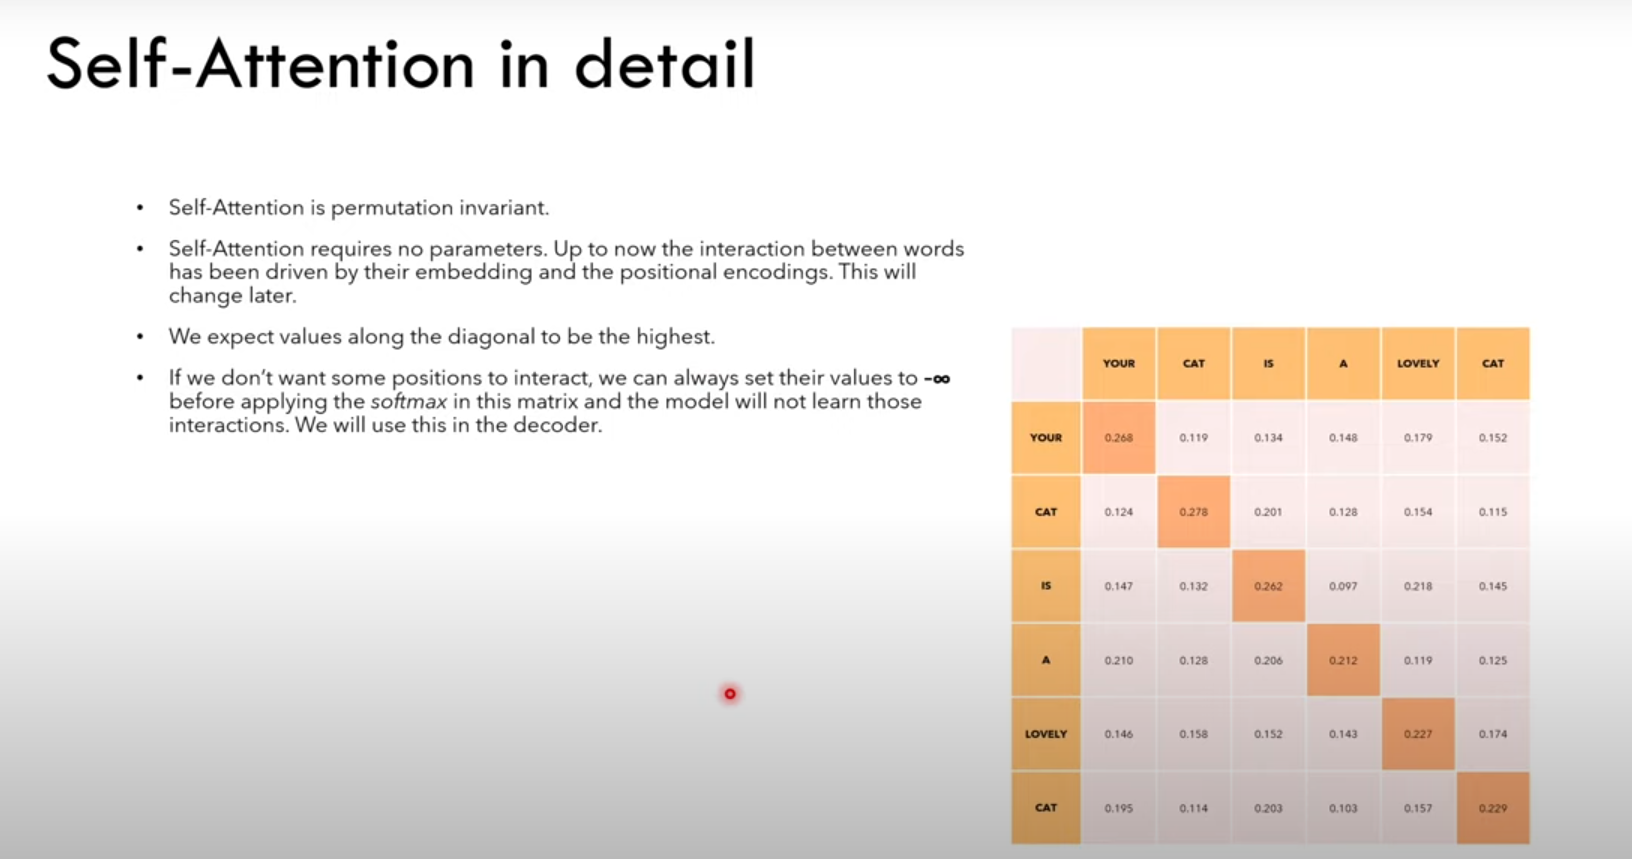

The matrix above shows the multiplication of the queries and the keys. As we are interested in each word only knowing the previous word, we want values in upper right traingle to be 0.

In [ ]:
# We want every word in decoder to only watch words that come before it
def causal_mask(size):
  mask = torch.triu(torch.ones(1, size, size), diagonal=1).type(torch.int)
  return mask == 0 # (1, seq_len, seq_len)

# Hyperparameters

In [ ]:
def get_config():
  return{
      "batch_size": 8,
      "num_epochs": 20,
      "lr": 10**-4,
      "seq_len": 350,
      "d_model": 512,
      "language_src": "en",
      "language_tgt": "it",
      "model_folder": "weights",
      "model_basename": "tmodel_",
      "preload": None,
      "tokenizer_file": "tokenizer_{0}.json",
      "experiment_name": "runs/tmodel"
  }

def get_weights_file_path(config, _epochs: str):
  model_folder =  config['model_folder']
  model_basename = config['model_basename']
  model_filename = f'{model_basename}{epoch}.pt'
  return str(Path(' ') / model_folder / model_filename)

# Greedy Decoding and Validation Functions for Seq2Seq Model with Tokenizer Handling

In [ ]:
def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
  sos_idx = tokenizer_tgt.token_to_id('[SOS]')
  eos_idx = tokenizer_tgt.token_to_id('[EOS]')

  #Precomput the encoder output and reuse it for every token we get from the decoder
  encoder_output = model.encode(source, source_mask)

  #Initialize decoder input with SOS token
  decoder_input = torch.empty(1,1).fill_(sos_idx).type_as(source).to(device) # (batch, decoder_input)
  while (True):
    if decoder_input.size(1) == max_len:
      break

    #Build mask for the target (decoder input)
    decoder_mask = causal_mask(decoder_input.size(1)).type_as(source_mask).to(device) #Don't want decoder_input to see any future words, therefore casual mask. Don't need other mask coz we don't have PAD tokens

    #Calculate the output of the decoder
    out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)

    #Get the next token
    prob = model.project(out[:,-1])

    #Select the token with the max probability (bcoz it's greedy search)
    _, next_word = torch.max(prob, dim=1)
    decoder_input = torch.cat([decoder_input, torch.empty(1,1).type_as(source).fill_(next_word.item()).to(device)], dim=1)

    if next_word == eos_idx:
      break

  return decoder_input.squeeze(0) # remove batch dimension

def run_validation(model, validation_dataset, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, global_state, writer, num_examples=2):
  model.eval()
  count = 0

  ''' source_texts = []
  expected = []
  predicted = [] '''

  #Size of the control window (just use a default value)
  console_width = 80

  with torch.no_grad():
    for batch in validation_dataset:
      count += 1
      encoder_input = batch['encoder_input'].to(device)
      encoder_mask = batch["encoder_mask"].to(device)

      assert encoder_input.size(0) == 1, "Batch size must be 1 for validation"
      model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)
      source_text = batch['src_text'][0]
      target_text = batch['tgt_text'][0]
      model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy())

      ''' source_texts.append(source_text)
      expected.append(target_text)
      predicted.append(model_out_text) '''

      #Print on the console... when tqdm progress bar is running we want it to print on the console... print_msg - fn of tqdm
      print_msg('-' * console_width)
      print_msg(f'SOURCE: {source_text}')
      print_msg(f'TARGET: {target_text}')
      print_msg(f'PREDICTED: {model_out_text}')

      if count == num_examples:
        break

  ''' if writer:
    #Torchmetrics, CharErrorRate, BLEU, WordErrorRate '''

def get_all_sentences(dataset, language):
  for item in dataset:
    yield item['translation'][language]

def get_or_build_tokenizer(config, dataset, language):
  tokenizer_path = Path(config['tokenizer_file'].format(language)) #sample usage... config['tokenizer_file'] = '../tokenizers/tokenizer_{0}.json'
  if not Path.exists(tokenizer_path):
    tokenizer = Tokenizer(WordLevel(unk_token='[UNK]'))
    tokenizer.pre_tokenizer = Whitespace()
    trainer = WordLevelTrainer(special_tokens = ['[UNK]', '[PAD]', '[SOS]', '[EOS]'], min_frequency = 2)
    tokenizer.train_from_iterator(get_all_sentences(dataset, language), trainer=trainer)
    tokenizer.save(str(tokenizer_path))
  else:
    tokenizer = Tokenizer.from_file(str(tokenizer_path))
  return tokenizer

# Dataset Preparation and Tokenizer Building

In [ ]:
def get_dataset(config):
  dataset_raw = load_dataset('opus_books', f'{config["language_src"]}-{config["language_tgt"]}', split='train')

  #Build tokenizers
  tokenizer_src = get_or_build_tokenizer(config, dataset_raw, config['language_src'])
  tokenizer_tgt = get_or_build_tokenizer(config, dataset_raw, config['language_tgt'])

  #Keep 90% for training and 10% validation
  train_dataset_size = int(0.9*len(dataset_raw))
  val_dataset_size = len(dataset_raw) - train_dataset_size
  train_dataset_raw, val_dataset_raw = random_split(dataset_raw, (train_dataset_size, val_dataset_size))

  train_dataset = BilingualDataset(train_dataset_raw, tokenizer_src, tokenizer_tgt, config['language_src'], config['language_tgt'], config['seq_len'])
  val_dataset = BilingualDataset(val_dataset_raw, tokenizer_src, tokenizer_tgt, config['language_src'], config['language_tgt'], config['seq_len'])

  max_len_src = 0
  max_len_tgt = 0

  for item in dataset_raw:
    src_ids = tokenizer_src.encode(item['translation'][config['language_src']]).ids
    tgt_ids = tokenizer_src.encode(item['translation'][config['language_tgt']]).ids
    max_len_src = max(max_len_src, len(src_ids))
    max_len_tgt = max(max_len_tgt, len(tgt_ids))

  print(f"Max length of source sentence: {max_len_src}")
  print(f"Max length of target sentence: {max_len_tgt}")

  train_dataloader = DataLoader(train_dataset, batch_size = config['batch_size'], shuffle = True)
  val_dataloader = DataLoader(val_dataset, batch_size = 1, shuffle = True)

  return train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt

In [ ]:
def get_model(config, vocab_src_len, vocab_tgt_len):
  model = build_transformer(vocab_src_len, vocab_tgt_len, config['seq_len'], config['seq_len'], config['d_model'])
  return model

# Train

In [ ]:
def train_model(config):
  #define the device
  device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
  print(f'Using device {device}')

  Path(config['model_folder']).mkdir(parents=True, exist_ok=True)

  train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_dataset(config)
  model = get_model(config, tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)

  #Tensorboard
  writer = SummaryWriter(config['experiment_name'])

  optimizer = torch.optim.Adam(model.parameters(), lr = config['lr'], eps=1e-9)

  initial_epoch = 0
  global_step = 0

  if config['preload']:
    model_filename = get_weights_file_path(config, config['preload'])
    print(f"Preloading model {model_filename}")
    state = torch.load(model_filename)
    initial_epoch = state['epoch'] + 1
    optimizer.load_state_dict(state['optimizer_state_dict'])
    global_step = state['global_state']

  loss_fn = nn.CrossEntropyLoss(ignore_index = tokenizer_src.token_to_id('[PAD]'), label_smoothing=0.1).to(device)

  for epoch in range(initial_epoch, config['num_epochs']):
    batch_iterator = tqdm(train_dataloader, desc = f'Processing epoch {epoch: 02d}')
    for batch in batch_iterator:
      model.train()

      encoder_input = batch['encoder_input'].to(device) # (batch_size, seq_len)
      decoder_input = batch['decoder_input'].to(device) # (batch_size, seq_len)
      encoder_mask = batch['encoder_mask'].to(device) # (batch_size, 1, 1, seq_len) Hide PAD tokens only
      decoder_mask = batch['decoder_mask'].to(device) # (batch_size, 1, seq_len, seq_len) Hide PAD tokens and subsequent words

      #Run the tensors through the transformer
      encoder_output = model.encode(encoder_input, encoder_mask) # (batch_size, seq_len, d_model)
      decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask) # (batch_size, seq_len, d_model)

      proj_output = model.project(decoder_output) # (batch_size, seq_len, target_vocab_size)

      label = batch['label'].to(device) # (batch_size, seq_len)

      loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1)) # (batch_size, seq_len, target_vocab_size) -> (batch_size * seq_len, target_vocab_size)
      batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})

      #Log the loss to tensorboard
      writer.add_scalar("train loss", loss.item(), global_step)
      writer.flush()

      #Backprop the loss
      loss.backward()

      #Update the weights
      optimizer.step()
      optimizer.zero_grad()

      global_step += 1

    run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: batch_iterator.write(msg), global_step, writer)

  #Save the model
  model_filename = get_weights_file_path(config, f'{epoch: 02d})')
  torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'global_step': global_step
  }, model_filename)

In [ ]:
if __name__ == '__main__':
  warnings.filterwarnings('ignore')
  config = get_config()
  train_model(config)

Using device cuda


Generating train split:   0%|          | 0/32332 [00:00<?, ? examples/s]

Max length of source sentence: 309
Max length of target sentence: 274


Processing epoch  0: 100%|██████████| 3638/3638 [24:52<00:00,  2.44it/s, loss=6.650]


--------------------------------------------------------------------------------
SOURCE: 'But I must give you time to finish your coffee,' answered Matthew in his friendly rude tone, with which it was impossible to be angry.
TARGET: — Bisogna pur darvi il tempo di prendere almeno il caffè — disse Matvej con quel tono fra il confidenziale e lo screanzato che non dava la possibilità di arrabbiarsi.
PREDICTED: — Non è un ’ è mai detto che non è un ’ ic — disse Levin .
--------------------------------------------------------------------------------
SOURCE: 'That's quite another question. I am prepared to admit that they are useful.
TARGET: — No, questa è un’altra questione; sono pronto a riconoscere che sono utili.
PREDICTED: — E la mia cosa è un ’ è un ’ è un ’ è un ’ è un ’ .


Processing epoch  1: 100%|██████████| 3638/3638 [24:55<00:00,  2.43it/s, loss=4.806]


--------------------------------------------------------------------------------
SOURCE: I drew better than her master in the first school in S-.
TARGET: Voi disegnate meglio del mio maestro della pensione di S....
PREDICTED: Io non avevo mai mai mai mai mai mai più di un uomo di .
--------------------------------------------------------------------------------
SOURCE: "Well, how wet and cold you must be, such a wild night as it is!
TARGET: — Come dovete esser bagnato e intirizzito con una notte come questa.
PREDICTED: — Ebbene , signore , e voi è un po ' di un po ' di una volta .


Processing epoch  2: 100%|██████████| 3638/3638 [24:54<00:00,  2.43it/s, loss=3.945]


--------------------------------------------------------------------------------
SOURCE: That is natural.
TARGET: E questo è comprensibile.
PREDICTED: È una donna .
--------------------------------------------------------------------------------
SOURCE: He ploughed the land for the potatoes with an English plough, which he had borrowed from a landowner.
TARGET: Egli arava sotto le patate con “l’aratra», come egli chiamava l’aratro preso in prestito dal proprietario.
PREDICTED: Egli si in una barca , con un uomo che aveva un ’ altra parte di un ’ altra conversazione .


Processing epoch  3: 100%|██████████| 3638/3638 [24:54<00:00,  2.43it/s, loss=5.056]


--------------------------------------------------------------------------------
SOURCE: Human beings never enjoy complete happiness in this world.
TARGET: Gli esseri mortali non godono mai di una completa felicità nel mondo.
PREDICTED: I nostri pensieri non hanno mai mai mai mai mai mai mai mai mai mai mai una felicità .
--------------------------------------------------------------------------------
SOURCE: After Friday and I became more intimately acquainted, and that he could understand almost all I said to him, and speak pretty fluently, though in broken English, to me, I acquainted him with my own history, or at least so much of it as related to my coming to this place: how I had lived there, and how long; I let him into the mystery, for such it was to him, of gunpowder and bullet, and taught him how to shoot.
TARGET: Scoperta importante. Poichè Venerdì ed io fummo entrati in maggiore intrinsichezza, ed egli potè intendere quasi tutto ciò ch’io gli dicea, e parlarmi speditamente,

Processing epoch  4:   3%|▎         | 124/3638 [00:50<24:01,  2.44it/s, loss=4.479]